*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<img style="padding: 10px; float:right;" alt="CC-BY-SA icon.svg in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/CC-BY-SA_icon.svg" width="125">


<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/notebooks/module05_01_cross_validation.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 0

Autosave disabled


# Evaluating classifiers:  cross validation 

### Learning curves

Intuitively, the more data we have available, the more accurate our classifiers become.  To demonstrate this, let's read in some data and evaluate a k-nearest neighbor classifier on a fixed test set with increasing number of training examples.  The resulting curve of accuracy as a function of number of examples is called a **learning curve**.



In [86]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = load_digits(return_X_y=True)

training_sizes = [20, 40, 100, 200, 400, 600, 800, 1000, 1200]

# note the use of the stratify keyword: it makes it so that each 
# class is equally represented in both train and test set
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size = len(y)-max(training_sizes), 
    stratify=y, random_state=1)

accuracy = []
for training_size in training_sizes :
    X_train,_ , y_train,_ = train_test_split(
        X_full_train, y_full_train, test_size = 
        len(y_full_train)-training_size+10, stratify=y_full_train)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(np.sum((y_pred==y_test))/len(y_test))


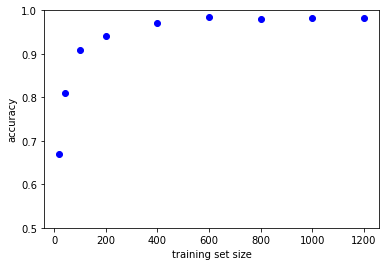

In [89]:
plt.figure(figsize=(6,4))
plt.plot(training_sizes, accuracy, 'ob')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.ylim((0.5,1));

It's also instructive to look at the numbers themselves:

In [4]:
print ("# training examples\t accuracy")
for i in range(len(accuracy)) :
    print ("\t{:d}\t\t {:f}".format(training_sizes[i], accuracy[i]))


# training examples	 accuracy
	20		 0.636516
	40		 0.889447
	100		 0.914573
	200		 0.953099
	400		 0.966499
	600		 0.979899
	800		 0.983250
	1000		 0.983250
	1200		 0.983250


### Exercise

* What can you conclude from this plot?  
* Why would you want to compute a learning curve on your data?


### Making better use of our data with cross validation

The discussion above demonstrates that it is best to have as large of a training set as possible.  We also need to have a large enough test set, so that the accuracy estimates are accurate.  How do we balance these two contradictory requirements?  Cross-validation provides us a more effective way to make use of our data.  Here it is:

**Cross validation**

* Randomly partition the data into $k$ subsets ("folds").
* Set one fold aside for evaluation and train a model on the remaining $k$ folds and evaluate it on the held-out fold.
* Repeat until each fold has been used for evaluation
* Compute accuracy by averaging over the accuracy estimates generated for each fold.

Here is an illustration of 8-fold cross validation:

<img style="padding: 10px; float:left;" alt="cross-validation by MBanuelos22 CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif">

     width="600">

As you can see, this procedure is more expensive than dividing your data into train and test set.  When dealing with relatively small datasets, which is when you want to use this procedure, this won't be an issue.

Typically cross-validation is used with the number of folds being in the range of 5-10.  An extreme case is when the number of folds equals the number of training examples.  This special case is called *leave-one-out cross-validation*.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn import metrics

Let's use the scikit-learn breast cancer dataset to demonstrate the use of cross-validation.

In [23]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

A scikit-learn data object is container object with whose interesting attributes are: 
  * ‘data’, the data to learn, 
  * ‘target’, the classification labels, 
  * ‘target_names’, the meaning of the labels,
  * ‘feature_names’, the meaning of the features, and 
  * ‘DESCR’, the full description of the dataset.



In [24]:
X = data.data
y = data.target
print('number of examples ', len(y))
print('number of features ', len(X[0]))

print(data.target_names)
print(data.feature_names)

number of examples  569
number of features  30
['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                                    random_state=0)
classifier = KNeighborsClassifier(n_neighbors=3)
#classifier = LogisticRegression()

_ = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


Let's compute the accuracy of our predictions:

In [9]:
np.mean(y_pred==y_test)

0.9385964912280702

We can do the same using scikit-learn:

In [10]:
metrics.accuracy_score(y_test, y_pred)

0.9385964912280702

Now let's compute accuracy using [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead:

In [11]:
accuracy = cross_val_score(classifier, X, y, cv=5, 
                           scoring='accuracy')
print(accuracy)

[0.87719298 0.92105263 0.94736842 0.93859649 0.91150442]


This yields an array containing the accuracy values for each fold.
When reporting your results, you will typically show the mean:

In [12]:
np.mean(accuracy)

0.9191429902189101

The arguments of `cross_val_score`:
* A classifier (anything that satisfies the scikit-learn classifier API)
* data (features/labels)
* `cv` : an integer that specifies the number of folds (can be used in more sophisticated ways as we will see below).
* `scoring`: this determines which accuracy measure is evaluated for each fold.  Here's a link to the  [list of available measures](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) in scikit-learn.

You can obtain accuracy for other metrics.  *Balanced accuracy* for example, is appropriate when the data is unbalanced (e.g. when one class contains a much larger number of examples than other classes in the data).

In [13]:
accuracy = cross_val_score(classifier, X, y, cv=5, 
                           scoring='balanced_accuracy')
np.mean(accuracy)

0.9080478348124925

`cross_val_score` is somewhat limited, in that it simply returns a list of accuracy scores.  In practice, we often want to have more information about what happened during training, and also to compute multiple accuracy measures.
`cross_validate` will provide you with that information:

In [14]:
results = cross_validate(classifier, X, y, cv=5, 
                         scoring='accuracy', return_estimator=True)
print(results)

{'fit_time': array([0.0010581 , 0.00099397, 0.00085902, 0.00093985, 0.00105977]), 'score_time': array([0.00650811, 0.00734997, 0.01043916, 0.00643301, 0.00529218]), 'estimator': (KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowsk

The object returned by `cross_validate` is a Python dictionary as the output suggests.  To extract a specific piece of data from this object, simply access the dictionary with the appropriate key:

In [15]:
results['test_score']

array([0.87719298, 0.92105263, 0.94736842, 0.93859649, 0.91150442])

If you would like to know the predictions made for each training example during cross-validation use [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) instead:

In [20]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(classifier, X, y, cv=5)
metrics.accuracy_score(y, y_pred)

0.9191564147627417

The above way of performing cross-validation doesn't always give us enough control on the process:  we usually want our machine learning experiments be reproducible, and to be able to use the same cross-validation splits with multiple algorithms.  The scikit-learn `KFold` and `StratifiedKFold` cross-validation generators are the way to achieve that.  

`KFold` simply chooses a random subset of examples for each fold.  This strategy can lead to cross-validation folds in which the classes are not well-represented as the following toy example demonstrates:

In [60]:
from sklearn.model_selection import StratifiedKFold, KFold

X_toy = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9,10], [11, 12]])
y_toy = np.array([0, 0, 1, 1, 1, 1])
cv = KFold(n_splits=2, random_state=3, shuffle=True)
for train_idx, test_idx in cv.split(X_toy, y_toy):
    print("train:", train_idx, "test:", test_idx)
    X_train, X_test = X_toy[train_idx], X_toy[test_idx]
    y_train, y_test = y_toy[train_idx], y_toy[test_idx]
    print(y_train)

train: [0 1 2] test: [3 4 5]
[0 0 1]
train: [3 4 5] test: [0 1 2]
[1 1 1]


`StratifiedKFold` addresses this issue by making sure that each class is represented in each fold in proportion to its overall fraction in the data.  This is particularly important when one or more of the classes have few examples.

`StratifiedKFold` and `KFold` generate folds that can be used in conjunction with the cross-validation methods we saw above.
As an example, we will demonstrate the use of `StratifiedKFold` with `cross_val_score` on the breast cancer datast:

In [27]:
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
accuracy = cross_val_score(classifier, X, y, cv=cv, 
                           scoring='accuracy')
np.mean(accuracy)

0.935010091600683

For classification problems, `StratifiedKFold` is the preferred strategy.  However, for regression problems `KFold` is the way to go.

#### Question

Why is `KFold` used in regression probelms rather than `StratifiedKFold`?

To clarify the distinction between the different methods of generating cross-validation folds and their different parameters let's look at the following figures:

In [81]:
# the code for the figure is adapted from
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

np.random.seed(42)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_folds = 4

# Generate the data
X = np.random.randn(100, 10)

# generate labels - classes 0,1,2 and 10,30,60 examples, respectively
y = np.array([0] * 10 + [1] * 30 + [2] * 60)

def plot_cv_indices(cv, X, y, ax, n_folds):
    """plot the indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.zeros(len(X))
        indices[tt] = 1
        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=15, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=15, cmap=cmap_data)

   # Formatting
    yticklabels = list(range(n_folds)) + ['class']
    ax.set(yticks=np.arange(n_folds+2) + .5, yticklabels=yticklabels, 
           xlabel='index', ylabel="CV fold",
           ylim=[n_folds+1.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


Let's visualize the results of using `KFold` for fold generation:

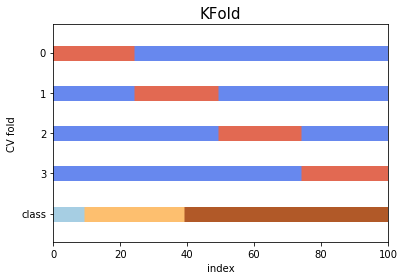

In [82]:
fig, ax = plt.subplots()
cv = KFold(n_folds)
plot_cv_indices(cv, X, y, ax, n_folds);

As you can see, this naive way of using `KFold` can lead to highly undesirable splits into cross-validation folds.
Using `StratifiedKFold` addresses this to some extent:

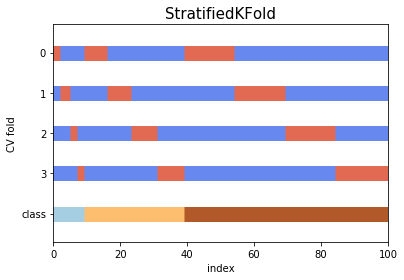

In [83]:
fig, ax = plt.subplots()
cv = StratifiedKFold(n_folds)
plot_cv_indices(cv, X, y, ax, n_folds);

Using `StratifiedKFold` with shuffling of the examples is the preferred way of splitting the data into folds:

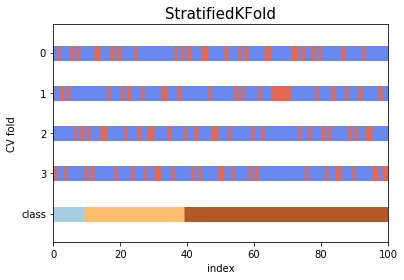

In [84]:
fig, ax = plt.subplots()
cv = StratifiedKFold(n_folds, shuffle=True)
plot_cv_indices(cv, X, y, ax, n_folds);

### Question

Consider the task of digitizing handwritten text (aka optical character recognition, or OCR).  For each letter in the alphabet you have multiple labeled examples generated by the same writer.  How would this setup affect the way you divide your examples into training and test sets, or when performing cross-validation?


### Summary and Discussion

In this notebook we discussed cross-validation as a more effective way to make use of limited amounts of data compared to the strategy of splitting data into train and test sets.  For very large datasets where training is  time consuming you might still opt for evaluation on a single test set.
